In [1]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import os
import numpy as np
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

C:\Users\olive\miniconda3\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
top_down_path = os.getcwd()
os.chdir("../Data")
data_path = os.getcwd()
os.chdir(top_down_path)

# Read data

In [3]:
# Read preprocessed
df = pd.read_csv(os.path.join(data_path, "preprocessed.csv"), index_col=0)
df.index = pd.to_datetime(df.index)

# Prepare regression data

In [4]:
dfx = df.copy()
dfx = dfx.rename(columns={
    'aggregated': 'w2h',
    'electricity_from_gas': 'power',
    'producing_sector': 'econ',
})

dfx = dfx[
    (dfx.holiday==0) & 
    (dfx.christmas_period==0) & 
    (dfx.bridgeday==0)
]

In [5]:
high_gas_date = "2021-09-01"
covid_beginning = "2020-02-01"
invasion_date = "2022-02-24"

Monthly treatment dummies from Sep 2021 onwards:

In [6]:
dummy_list = []
for date in pd.date_range('2021-09', '2022-04', freq='1m'):
    dummy_name = f'd{date.year}_{date.month}'
    dfx.loc[dfx.index, dummy_name] = dfx.index.map(
        lambda x: (x.year==date.year) & (x.month==date.month)
    ).values
    dummy_list.append(dummy_name)

In [7]:
dfx

,slp,rlm,gas_to_electricity,power,gas_price [€/MWh],econ,residential,commercial,decentral_chp,industry_buildings,...,christmas_period,holiday,bridgeday,d2021_9,d2021_10,d2021_11,d2021_12,d2022_1,d2022_2,d2022_3
2017-01-02,2.362777,2.056043,0.549828,234.902217,NaN,91.7,1.423058,0.670494,0.102627,0.171044,...,0,0,0,False,False,False,False,False,False,False
2017-01-03,2.284347,2.030095,0.453608,193.794329,NaN,91.7,1.362678,0.635979,0.097344,0.162240,...,0,0,0,False,False,False,False,False,False,False
2017-01-04,2.203892,2.108759,0.465417,198.839085,NaN,91.7,1.305515,0.598531,0.091612,0.152686,...,0,0,0,False,False,False,False,False,False,False
2017-01-05,2.509253,2.358004,0.763463,326.173074,NaN,91.7,1.441746,0.680565,0.104168,0.173613,...,0,0,0,False,False,False,False,False,False,False
2017-01-07,2.758369,2.134451,0.553247,236.362591,NaN,91.7,1.691065,0.740020,0.113268,0.188781,...,0,0,0,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-21,1.392489,1.760465,0.571950,244.353213,96.302,106.9,0.909151,0.379785,0.058130,0.096884,...,0,0,0,False,False,False,False,False,False,True
2022-03-22,1.298477,1.775411,0.725432,309.925058,98.745,106.9,0.852247,0.348559,0.053351,0.088918,...,0,0,0,False,False,False,False,False,False,True
2022-03-23,1.192763,1.735938,0.749840,320.352790,117.000,106.9,0.802116,0.318578,0.048762,0.081270,...,0,0,0,False,False,False,False,False,False,True
2022-03-24,1.139401,1.730537,0.762009,325.551653,111.610,106.9,0.780445,0.309264,0.047336,0.078894,...,0,0,0,False,False,False,False,False,False,True


In [8]:
def extract_results(results, log=True):
    extracted_results = pd.concat(
        [results.params, results.bse], keys=['coef', 'se'], axis=1
    )
    extracted_results = extracted_results*100 if log else extracted_results
    extracted_results = extracted_results.loc[[d + '[T.True]' for d in dummy_list]]
    extracted_results.index = dummy_list
    extracted_results['low'] = extracted_results['coef'] - 2 * extracted_results['se']
    extracted_results['high'] = extracted_results['coef'] + 2 * extracted_results['se']
    return extracted_results

# SLP regression
Log-linear model

In [9]:
dfx['log_slp'] = np.log(dfx['slp'])

model = 'log_slp ~ 1 + w2h + time + C(weekday) + C(month) + ' + ' + '.join(dummy_list)
results_slp_log = smf.ols(model, dfx).fit(cov_type='HAC', cov_kwds={'maxlags':6})

results_slp_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_slp   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     480.0
Date:                Mon, 20 Jun 2022   Prob (F-statistic):               0.00
Time:                        18:22:36   Log-Likelihood:                 751.88
No. Observations:                1764   AIC:                            -1450.
Df Residuals:                    1737   BIC:                            -1302.
Df Model:                          26                                         
Covariance Type:                  HAC                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.8885      0.079    -11.303      0.000      -1.043      -0.734
C(weekday)[T.Monday]       -0.0103      0.010     -1.059      0.290      -0.029       0.009
C(weekday)[T.Saturday]      0.0021      0.006      0.336      0.737      -0.010       0.014
C(weekday)[T.Sunday]        0.0007      0.009      0.080      0.936      -0.016       0.017
C(weekday)[T.Thursday]     -0.0030      0.007     -0.437      0.662      -0.017       0.010
C(weekday)[T.Tuesday]      -0.0024      0.010     -0.239      0.811      -0.022       0.017
C(weekday)[T.Wednesday]    -0.0022      0.009     -0.250      0.802      -0.020       0.015
C(month)[T.2]               0.0378      0.039      0.979      0.328      -0.038       0.114
C(month)[T.3]               0.0836      0.033      2.553      0.011       0.019       0.148
C(month)[T.4]              -0.0101      0.044     -0.227      0.821      -0.097       0.077
C(month)[T.5]              -0.2236      0.068     -3.311      0.001      -0.356      -0.091
C(month)[T.6]              -0.7008      0.075     -9.366      0.000      -0.848      -0.554
C(month)[T.7]              -0.7620      0.074    -10.250      0.000      -0.908      -0.616
C(month)[T.8]              -0.7787      0.076    -10.252      0.000      -0.928      -0.630
C(month)[T.9]              -0.3642      0.073     -5.009      0.000      -0.507      -0.222
C(month)[T.10]             -0.0417      0.051     -0.824      0.410      -0.141       0.058
C(month)[T.11]              0.0819      0.030      2.770      0.006       0.024       0.140
C(month)[T.12]              0.0908      0.026      3.561      0.000       0.041       0.141
d2021_9[T.True]            -0.0616      0.078     -0.785      0.432      -0.215       0.092
d2021_10[T.True]            0.0214      0.037      0.577      0.564      -0.051       0.094
d2021_11[T.True]           -0.0778      0.030     -2.563      0.010      -0.137      -0.018
d2021_12[T.True]           -0.1736      0.048     -3.619      0.000      -0.268      -0.080
d2022_1[T.True]            -0.0387      0.040     -0.963      0.335      -0.118       0.040
d2022_2[T.True]             0.0212      0.040      0.530      0.596      -0.057       0.099
d2022_3[T.True]            -0.1131      0.047     -2.430      0.015      -0.204      -0.022
w2h                         0.7461      0.035     21.615      0.000       0.678       0.814
time                     4.499e-05   1.79e-05      2.510      0.012    9.86e-06    8.01e-05
==============================================================================
Omnibus:                      191.972   Durbin-Watson:                   0.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              359.129
Skew:                          -0.707   Prob(JB):                     1.04e-78
Kurtosi

(-30.0, 15.0)

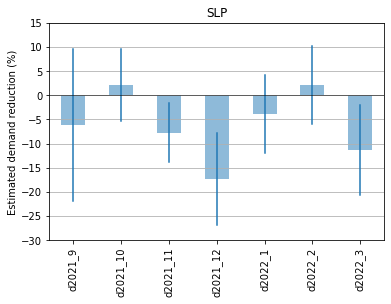

In [10]:
extracted_results = extract_results(results_slp_log)
ax = extracted_results['coef'].plot(kind='bar',alpha=0.5)
for d in dummy_list:
    plt.plot([d,d], [extracted_results.loc[d, 'low'], extracted_results.loc[d, 'high']], color='tab:blue')
    
plt.grid(axis='y')
plt.axhline(0, color='black', linewidth=0.5)
plt.ylabel('Estimated demand reduction (%)')
plt.title('SLP')
plt.ylim(-30, 15)

Linear model

In [11]:
model = 'slp ~ 1 + w2h + time + C(weekday) + C(month) + ' + ' + '.join(dummy_list)
results_slp = smf.ols(model, dfx).fit(cov_type='HAC', cov_kwds={'maxlags':6})

results_slp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    slp   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     9014.
Date:                Mon, 20 Jun 2022   Prob (F-statistic):               0.00
Time:                        18:22:38   Log-Likelihood:                 2786.1
No. Observations:                1764   AIC:                            -5518.
Df Residuals:                    1737   BIC:                            -5370.
Df Model:                          26                                         
Covariance Type:                  HAC                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.1985      0.021      9.609      0.000       0.158       0.239
C(weekday)[T.Monday]       -0.0074      0.004     -1.982      0.048      -0.015   -8.06e-05
C(weekday)[T.Saturday]      0.0012      0.003      0.477      0.633      -0.004       0.006
C(weekday)[T.Sunday]        0.0026      0.003      0.741      0.459      -0.004       0.009
C(weekday)[T.Thursday]     -0.0028      0.003     -1.008      0.313      -0.008       0.003
C(weekday)[T.Tuesday]      -0.0058      0.004     -1.464      0.143      -0.014       0.002
C(weekday)[T.Wednesday]    -0.0049      0.004     -1.400      0.162      -0.012       0.002
C(month)[T.2]              -0.0010      0.017     -0.059      0.953      -0.034       0.032
C(month)[T.3]              -0.0639      0.016     -3.962      0.000      -0.096      -0.032
C(month)[T.4]              -0.1429      0.017     -8.180      0.000      -0.177      -0.109
C(month)[T.5]              -0.1806      0.019     -9.762      0.000      -0.217      -0.144
C(month)[T.6]              -0.1726      0.020     -8.822      0.000      -0.211      -0.134
C(month)[T.7]              -0.1764      0.019     -9.131      0.000      -0.214      -0.139
C(month)[T.8]              -0.1809      0.019     -9.356      0.000      -0.219      -0.143
C(month)[T.9]              -0.1918      0.020     -9.603      0.000      -0.231      -0.153
C(month)[T.10]             -0.1515      0.018     -8.273      0.000      -0.187      -0.116
C(month)[T.11]             -0.0812      0.018     -4.622      0.000      -0.116      -0.047
C(month)[T.12]              0.0072      0.018      0.403      0.687      -0.028       0.042
d2021_9[T.True]             0.0398      0.014      2.890      0.004       0.013       0.067
d2021_10[T.True]           -0.0109      0.020     -0.539      0.590      -0.051       0.029
d2021_11[T.True]           -0.0216      0.017     -1.301      0.193      -0.054       0.011
d2021_12[T.True]           -0.0883      0.025     -3.502      0.000      -0.138      -0.039
d2022_1[T.True]            -0.0217      0.015     -1.418      0.156      -0.052       0.008
d2022_2[T.True]             0.0055      0.013      0.408      0.683      -0.021       0.032
d2022_3[T.True]            -0.0533      0.013     -4.100      0.000      -0.079      -0.028
w2h                         0.9156      0.007    127.097      0.000       0.901       0.930
time                    -1.342e-05   5.29e-06     -2.539      0.011   -2.38e-05   -3.06e-06
==============================================================================
Omnibus:                       64.157   Durbin-Watson:                   0.531
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.313
Skew:                           0.115   Prob(JB):                     4.66e-37
Kurtosi

(-0.15, 0.1)

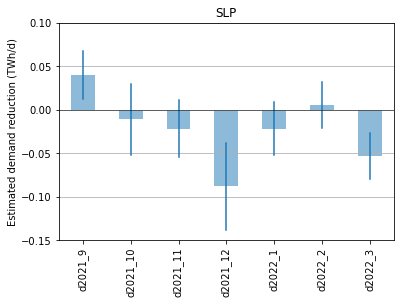

In [14]:
extracted_results = extract_results(results_slp, log=False)
ax = extracted_results['coef'].plot(kind='bar',alpha=0.5)
for d in dummy_list:
    plt.plot([d,d], [extracted_results.loc[d, 'low'], extracted_results.loc[d, 'high']], color='tab:blue')
    
plt.grid(axis='y')
plt.axhline(0, color='black', linewidth=0.5)
plt.ylabel('Estimated demand reduction (TWh/d)')
plt.title('SLP')
plt.ylim(-0.15, 0.1)

# RLM
Loglinear model

In [16]:
dfx['log_rlm'] = np.log(dfx['rlm'])

results_rlm_log = {}
for m in ['temp', 'temp+power', 'temp+power+econ']:
    model = 'log_rlm ~ 1 + w2h + time + C(weekday) + C(month) + ' + ' + '.join(dummy_list)
    if 'power' in m:
        model += ' + power'
    if 'econ' in m:
        model += ' + econ'
    results_rlm_log[m] = smf.ols(model, dfx).fit(cov_type='HAC', cov_kwds={'maxlags':6})

results_rlm_log['temp'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_rlm   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     601.4
Date:                Mon, 20 Jun 2022   Prob (F-statistic):               0.00
Time:                        18:22:59   Log-Likelihood:                 2670.3
No. Observations:                1764   AIC:                            -5287.
Df Residuals:                    1737   BIC:                            -5139.
Df Model:                          26                                         
Covariance Type:                  HAC                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.2887      0.015     18.662      0.000       0.258       0.319
C(weekday)[T.Monday]        0.0319      0.004      8.784      0.000       0.025       0.039
C(weekday)[T.Saturday]     -0.1606      0.003    -49.015      0.000      -0.167      -0.154
C(weekday)[T.Sunday]       -0.1630      0.004    -43.896      0.000      -0.170      -0.156
C(weekday)[T.Thursday]      0.0399      0.003     12.647      0.000       0.034       0.046
C(weekday)[T.Tuesday]       0.0427      0.004     11.183      0.000       0.035       0.050
C(weekday)[T.Wednesday]     0.0423      0.004     11.616      0.000       0.035       0.049
C(month)[T.2]              -0.0123      0.009     -1.373      0.170      -0.030       0.005
C(month)[T.3]              -0.0521      0.012     -4.222      0.000      -0.076      -0.028
C(month)[T.4]              -0.1027      0.014     -7.104      0.000      -0.131      -0.074
C(month)[T.5]              -0.1174      0.013     -8.923      0.000      -0.143      -0.092
C(month)[T.6]              -0.0967      0.015     -6.387      0.000      -0.126      -0.067
C(month)[T.7]              -0.0960      0.016     -5.954      0.000      -0.128      -0.064
C(month)[T.8]              -0.1283      0.018     -7.330      0.000      -0.163      -0.094
C(month)[T.9]              -0.0632      0.017     -3.827      0.000      -0.095      -0.031
C(month)[T.10]             -0.0085      0.013     -0.640      0.522      -0.035       0.018
C(month)[T.11]              0.0135      0.010      1.336      0.181      -0.006       0.033
C(month)[T.12]             -0.0020      0.011     -0.181      0.857      -0.024       0.020
d2021_9[T.True]            -0.0847      0.014     -5.947      0.000      -0.113      -0.057
d2021_10[T.True]           -0.1262      0.012    -10.733      0.000      -0.149      -0.103
d2021_11[T.True]           -0.0514      0.011     -4.656      0.000      -0.073      -0.030
d2021_12[T.True]           -0.0412      0.025     -1.632      0.103      -0.091       0.008
d2022_1[T.True]            -0.0596      0.017     -3.588      0.000      -0.092      -0.027
d2022_2[T.True]            -0.0790      0.009     -9.080      0.000      -0.096      -0.062
d2022_3[T.True]            -0.0656      0.018     -3.601      0.000      -0.101      -0.030
w2h                         0.2146      0.006     35.623      0.000       0.203       0.226
time                     1.324e-05   5.71e-06      2.317      0.020    2.04e-06    2.44e-05
==============================================================================
Omnibus:                      100.061   Durbin-Watson:                   0.607
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.988
Skew:                          -0.507   Prob(JB):                     1.09e-30
Kurtosi

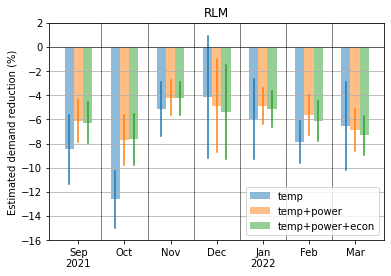

In [17]:
colors = ['tab:blue', 'tab:orange', 'tab:green']

for i, m in enumerate(['temp', 'temp+power', 'temp+power+econ']):
    
    extracted_results = extract_results(results_rlm_log[m])
    
    idx = [j-0.2+0.2*i for j in range(len(extracted_results))]
    plt.bar(idx, extracted_results['coef'], width=0.2,alpha=0.5, label=m)
    for j, d in enumerate(dummy_list):
        plt.plot([idx[j],idx[j]], [extracted_results.loc[d, 'low'], extracted_results.loc[d, 'high']], 
                 color=colors[i])
        
for i in range(len(extracted_results)-1):
    plt.axvline(i+0.5, color='black', linewidth=0.5)

plt.grid(axis='y')
plt.axhline(0, color='black', linewidth=0.5)
plt.ylabel('Estimated demand reduction (%)')
plt.title('RLM')
plt.ylim(-16, 2)
plt.xticks(range(len(extracted_results)), 
           [f'{date.month_name()[:3]}'+(
               '\n2021' if date.month==9 else (
                   '\n2022' if date.month==1 else ''
               )
           ) for date in pd.date_range('2021-09', '2022-04', freq='1m')])    
plt.legend(loc='lower right')
plt.savefig('rlm_log.png', dpi=300)

In [18]:
dfx['log_rlm'] = np.log(dfx['rlm'])

results_rlm = {}
for m in ['temp', 'temp+power', 'temp+power+econ']:
    model = 'rlm ~ 1 + w2h + time + C(weekday) + C(month) + ' + ' + '.join(dummy_list)
    if 'power' in m:
        model += ' + power'
    if 'econ' in m:
        model += ' + econ'
    results_rlm[m] = smf.ols(model, dfx).fit(cov_type='HAC', cov_kwds={'maxlags':6})

results_rlm['temp'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    rlm   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     580.5
Date:                Mon, 20 Jun 2022   Prob (F-statistic):               0.00
Time:                        18:23:07   Log-Likelihood:                 1840.4
No. Observations:                1764   AIC:                            -3627.
Df Residuals:                    1737   BIC:                            -3479.
Df Model:                          26                                         
Covariance Type:                  HAC                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   1.2921      0.030     42.793      0.000       1.233       1.351
C(weekday)[T.Monday]        0.0532      0.006      8.499      0.000       0.041       0.065
C(weekday)[T.Saturday]     -0.2372      0.005    -50.841      0.000      -0.246      -0.228
C(weekday)[T.Sunday]       -0.2405      0.006    -43.693      0.000      -0.251      -0.230
C(weekday)[T.Thursday]      0.0646      0.005     12.007      0.000       0.054       0.075
C(weekday)[T.Tuesday]       0.0682      0.007     10.248      0.000       0.055       0.081
C(weekday)[T.Wednesday]     0.0676      0.006     10.523      0.000       0.055       0.080
C(month)[T.2]              -0.0281      0.020     -1.395      0.163      -0.068       0.011
C(month)[T.3]              -0.1141      0.024     -4.692      0.000      -0.162      -0.066
C(month)[T.4]              -0.1739      0.026     -6.731      0.000      -0.225      -0.123
C(month)[T.5]              -0.1691      0.025     -6.880      0.000      -0.217      -0.121
C(month)[T.6]              -0.1006      0.028     -3.628      0.000      -0.155      -0.046
C(month)[T.7]              -0.0993      0.028     -3.519      0.000      -0.155      -0.044
C(month)[T.8]              -0.1422      0.030     -4.747      0.000      -0.201      -0.084
C(month)[T.9]              -0.0798      0.029     -2.750      0.006      -0.137      -0.023
C(month)[T.10]             -0.0242      0.026     -0.937      0.349      -0.075       0.026
C(month)[T.11]              0.0061      0.021      0.285      0.775      -0.036       0.048
C(month)[T.12]             -0.0175      0.023     -0.759      0.448      -0.063       0.028
d2021_9[T.True]            -0.1050      0.023     -4.596      0.000      -0.150      -0.060
d2021_10[T.True]           -0.2032      0.019    -10.668      0.000      -0.240      -0.166
d2021_11[T.True]           -0.0875      0.020     -4.358      0.000      -0.127      -0.048
d2021_12[T.True]           -0.0663      0.043     -1.531      0.126      -0.151       0.019
d2022_1[T.True]            -0.1154      0.032     -3.606      0.000      -0.178      -0.053
d2022_2[T.True]            -0.1575      0.017     -9.469      0.000      -0.190      -0.125
d2022_3[T.True]            -0.1091      0.034     -3.253      0.001      -0.175      -0.043
w2h                         0.3861      0.012     33.396      0.000       0.363       0.409
time                     1.649e-05   8.89e-06      1.856      0.063   -9.24e-07    3.39e-05
==============================================================================
Omnibus:                      147.134   Durbin-Watson:                   0.585
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              302.762
Skew:                          -0.537   Prob(JB):                     1.80e-66
Kurtosi

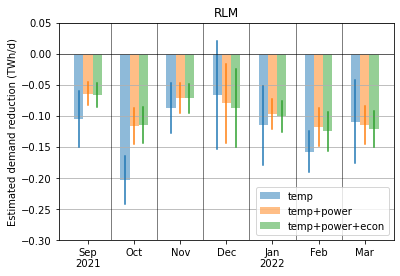

In [19]:
colors = ['tab:blue', 'tab:orange', 'tab:green']

for i, m in enumerate(['temp', 'temp+power', 'temp+power+econ']):
    
    extracted_results = extract_results(results_rlm[m], log=False)
    
    idx = [j-0.2+0.2*i for j in range(len(extracted_results))]
    plt.bar(idx, extracted_results['coef'], width=0.2,alpha=0.5, label=m)
    for j, d in enumerate(dummy_list):
        plt.plot([idx[j],idx[j]], [extracted_results.loc[d, 'low'], extracted_results.loc[d, 'high']], 
                 color=colors[i])
        
for i in range(len(extracted_results)-1):
    plt.axvline(i+0.5, color='black', linewidth=0.5)

plt.grid(axis='y')
plt.axhline(0, color='black', linewidth=0.5)
plt.ylabel('Estimated demand reduction (TWh/d)')
plt.title('RLM')
plt.ylim(-0.3, 0.05)
plt.xticks(range(len(extracted_results)), 
           [f'{date.month_name()[:3]}'+(
               '\n2021' if date.month==9 else (
                   '\n2022' if date.month==1 else ''
               )
           ) for date in pd.date_range('2021-09', '2022-04', freq='1m')])    
plt.legend(loc='lower right')
plt.savefig('rlm.png', dpi=300)

# Disaggregation based on fundamental assumption / energy balances

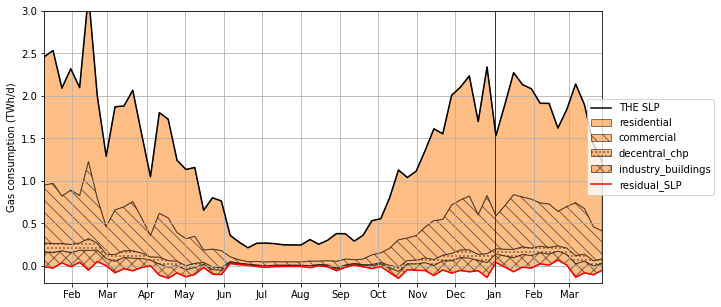

In [31]:
plt.figure(figsize=(10,5))

#weekly
dft = df.resample("1w").mean().dropna()
plt.xlim(dft.index[[0, -1]])

upper=dft['slp']
plt.plot(dft.index, dft['slp'], label='THE SLP', color="k")

for sector, h in [
    ("residential", ""), 
    ("commercial",  "\\\\"), 
    ("decentral_chp", "..."),
    ("industry_buildings", "XX")
]:
    plt.fill_between(
        dft.index, upper-dft[sector], upper, label=sector,
        color="tab:orange", hatch=h, edgecolor="k", alpha=0.5)
    upper = upper-dft[sector]

plt.plot(upper.index, upper, color="red", label="residual_SLP")

plt.ylim(-0.2, 3)
plt.axvline(pd.Timestamp('2022-01-01'), color='black', linewidth=0.7)
plt.grid()
plt.legend(loc='center right', bbox_to_anchor=(1.21, 0.5))
plt.ylabel('Gas consumption (TWh/d)')

X = plt.gca().xaxis
X.set_major_locator(mdates.MonthLocator())
X.set_major_formatter(mdates.DateFormatter('%b'))

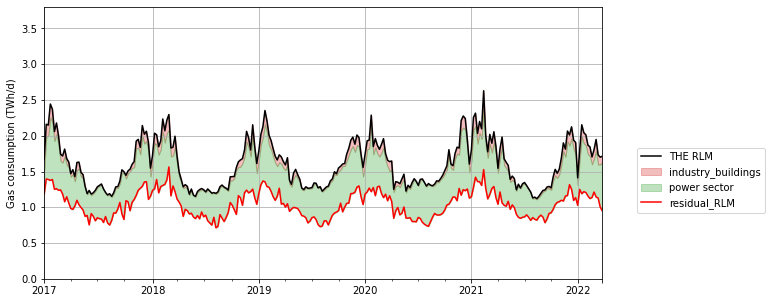

In [33]:
plt.figure(figsize=(10,5))

dft= df.resample("1w").mean()
the_rlm = dft['rlm']
the_rlm.plot(label='THE RLM', color="k")

power_res = the_rlm - dft['gas_to_electricity']
industry = dft["industry_buildings"]

upper=the_rlm
for sector, c, label in [
    (industry,"tab:red","industry_buildings"), 
    (dft['gas_to_electricity'],  "tab:green", "power sector")
    # (dft["scaled_district_heat"], "tab:orange", "dist_heat")
]: 
    plt.fill_between(dft.index, upper-sector, upper , color="{}".format(c), alpha=0.3, label=label)
    upper = upper-sector 

upper.plot(color="red", label="residual_RLM")

plt.xlim(power_res.dropna().index[[0, -1]])
plt.ylim(0, 3.8)
#plt.axvline('2022-01-01', color='black', linewidth=0.7)
plt.grid()
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 0.5))
plt.ylabel('Gas consumption (TWh/d)')

plt.show()

In [119]:
#SLP
model_the_slp = smf.ols(
    'slp ~ 1 + w2h + C(weekday) + C(month)', 
    data=dfx.loc[(dfx.index <= high_gas_date)&(dfx.index >= '2016-10-01')]
)
results_the_slp = model_the_slp.fit(cov_type='HAC', cov_kwds={'maxlags':6}) 
#results_the_slp.summary()



In [120]:
the_slp_prediction = results_the_slp.predict(df_x_no_holiday[df_x_no_holiday.index.year>=2021])
the_slp_prediction.name = "the_slp_forecast"

the_slp_combined = pd.concat([
    the_slp_prediction, df_x_no_holiday.loc[df_x_no_holiday.index.year>=2021]["slp"]
], axis=1, keys=["predicted", "reported"])

the_slp_combined.resample("1w").sum().plot(ylim=0).set_ylabel("gas consumption [TWh/w]")
plt.axvline(x="2022-02-24", color='k', linestyle='--', lw=1.2)
plt.grid() 


plt.show()

delta_the_slp = the_slp_combined.iloc[:,1]-the_slp_combined.iloc[:,0]

ax = delta_the_slp.loc[delta_the_slp.index.year==2022].resample("w").sum().plot()
ax.axvline(x=invasion_date, color='k', linestyle='-.', lw=1.2 )
ax.axhline(y=0, color='k', lw=1)
plt.grid()
ax.set_xlabel("year",fontsize=14)
ax.set_ylabel("regression delta [TWh/w]", fontsize=14)




NameError: name 'df_x_no_holiday' is not defined

In [16]:
mean_rlm_the = df_x_no_holiday['rlm'].mean()

normalized_results = extracted_results/mean_rlm_the*100

#calculate normalized results by division by mean of rlm_the across entire sample (without log transformation, using original rlm_the)

model = 'rlm ~ 1 + slp_w2h + time + C(weekday) + C(month) + ' + ' + '.join(dummy_list)
results = smf.ols(model, df_x_no_holiday).fit(cov_type='HAC', cov_kwds={'maxlags':6})

extracted_results = pd.concat(
    [results.params, results.HC0_se], keys=['coef', 'se'], axis=1
)
extracted_results = extracted_results.loc[[d + '[T.True]' for d in dummy_list]]
extracted_results.index = dummy_list
extracted_results['low'] = extracted_results['coef'] - 2 * extracted_results['se']
extracted_results['high'] = extracted_results['coef'] + 2 * extracted_results['se']
extracted_results

,coef,se,low,high
d2021_9,-0.057950,0.009638,-0.077225,-0.038675
d2021_10,0.631663,0.015212,0.601239,0.662087
d2021_11,0.894159,0.025665,0.842830,0.945488
d2021_12,0.976835,0.031222,0.914391,1.039279
d2022_1,0.924711,0.031803,0.861106,0.988317
d2022_2,0.832602,0.015844,0.800914,0.864290
d2022_3,0.824907,0.025183,0.774542,0.875272


(-40.0, 2.0)

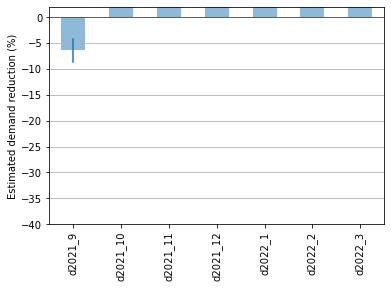

In [17]:
mean_rlm_the = df_x_no_holiday['rlm'].mean()

normalized_results = extracted_results/mean_rlm_the*100

ax = normalized_results['coef'].plot(kind='bar',alpha=0.5)
for d in dummy_list:
    plt.plot([d,d], [normalized_results.loc[d, 'low'], normalized_results.loc[d, 'high']], color='tab:blue')
    
plt.grid(axis='y')
plt.axhline(0, color='black', linewidth=0.5)
plt.ylabel('Estimated demand reduction (%)')
plt.ylim(-40, 2)
#plt.xticklabels()

## linear model

In [18]:
df = pd.DataFrame(range(1,6))
df['sq'] = df[0].map(lambda x: x**2)
df

,0,sq
0,1,1
1,2,4
2,3,9
3,4,16
4,5,25


In [19]:
model = 'rlm ~ 1 + slp_w2h + time + C(weekday) + C(month) + ' + ' + '.join(dummy_list)
results = smf.ols(model, df_x_no_holiday).fit(cov_type='HAC', cov_kwds={'maxlags':6})

In [20]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    rlm   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     1758.
Date:                Fri, 17 Jun 2022   Prob (F-statistic):               0.00
Time:                        17:19:49   Log-Likelihood:                 2251.3
No. Observations:                1751   AIC:                            -4449.
Df Residuals:                    1724   BIC:                            -4301.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.6203      0.012     49.851      0.000       0.596       0.645
C(weekday)[T.Monday]        0.0264      0.006      4.344      0.000       0.015       0.038
C(weekday)[T.Saturday]     -0.1353      0.006    -22.379      0.000      -0.147      -0.123
C(weekday)[T.Sunday]       -0.1373      0.006    -22.642      0.000      -0.149      -0.125
C(weekday)[T.Thursday]      0.0295      0.006      4.840      0.000       0.018       0.041
C(weekday)[T.Tuesday]       0.0409      0.006      6.762      0.000       0.029       0.053
C(weekday)[T.Wednesday]     0.0395      0.006      6.533      0.000       0.028       0.051
C(month)[T.2]              -0.0188      0.008     -2.314      0.021      -0.035      -0.003
C(month)[T.3]              -0.0467      0.008     -5.613      0.000      -0.063      -0.030
C(month)[T.4]              -0.0756      0.010     -7.807      0.000      -0.095      -0.057
C(month)[T.5]              -0.0742      0.011     -6.905      0.000      -0.095      -0.053
C(month)[T.6]              -0.0251      0.012     -2.060      0.040      -0.049      -0.001
C(month)[T.7]              -0.0284      0.012     -2.347      0.019      -0.052      -0.005
C(month)[T.8]              -0.0539      0.012     -4.427      0.000      -0.078      -0.030
C(month)[T.9]              -0.0160      0.012     -1.376      0.169      -0.039       0.007
C(month)[T.10]              0.0039      0.011      0.373      0.709      -0.017       0.025
C(month)[T.11]              0.0146      0.009      1.623      0.105      -0.003       0.032
C(month)[T.12]             -0.0027      0.009     -0.286      0.775      -0.021       0.016
d2021_9[T.True]            -0.0579      0.014     -4.072      0.000      -0.086      -0.030
d2021_10[T.True]            0.6317      0.015     43.202      0.000       0.603       0.660
d2021_11[T.True]            0.8942      0.015     61.266      0.000       0.866       0.923
d2021_12[T.True]            0.9768      0.017     57.406      0.000       0.943       1.010
d2022_1[T.True]             0.9247      0.015     62.126      0.000       0.896       0.954
d2022_2[T.True]             0.8326      0.014     57.594      0.000       0.804       0.861
d2022_3[T.True]             0.8249      0.015     54.196      0.000       0.795       0.855
slp_w2h                     0.4175      0.010     43.613      0.000       0.399       0.436
time                     1.193e-06   7.05e-07      1.692      0.091    -1.9e-07    2.58e-06
==============================================================================
Omnibus:                       95.290   Durbin-Watson:                   1.142
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              327.866
Skew:                          -0.146   Prob(JB):                     6.38e-72
Kurtosi

In [21]:
extracted_results = pd.concat(
    [results.params, results.HC0_se], keys=['coef', 'se'], axis=1
)
extracted_results = extracted_results.loc[[d + '[T.True]' for d in dummy_list]]
extracted_results.index = dummy_list
extracted_results['low'] = extracted_results['coef'] - 2 * extracted_results['se']
extracted_results['high'] = extracted_results['coef'] + 2 * extracted_results['se']
extracted_results

,coef,se,low,high
d2021_9,-0.057950,0.009638,-0.077225,-0.038675
d2021_10,0.631663,0.015212,0.601239,0.662087
d2021_11,0.894159,0.025665,0.842830,0.945488
d2021_12,0.976835,0.031222,0.914391,1.039279
d2022_1,0.924711,0.031803,0.861106,0.988317
d2022_2,0.832602,0.015844,0.800914,0.864290
d2022_3,0.824907,0.025183,0.774542,0.875272


(-0.6, 0.05)

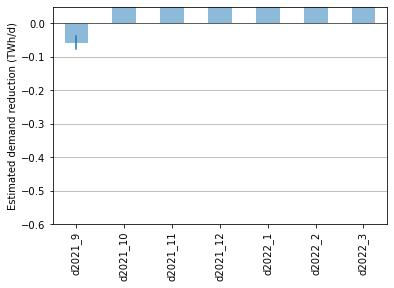

In [22]:
ax = extracted_results['coef'].plot(kind='bar',alpha=0.5)
for d in dummy_list:
    plt.plot([d,d], [extracted_results.loc[d, 'low'], extracted_results.loc[d, 'high']], color='tab:blue')
    
plt.grid(axis='y')
plt.axhline(0, color='black', linewidth=0.5)
plt.ylabel('Estimated demand reduction (TWh/d)')
plt.ylim(-0.6, 0.05)

# Regression variations

## Prices

In [23]:
model_the_prices = smf.ols('rlm ~ 1 + prices + slp_w2h + electricity_from_gas + producing_sector + C(weekday)', 
                            data=df_x_no_holiday)
results_the_prices = model_the_prices.fit(cov_type='HAC', cov_kwds={'maxlags':6}) 
#results_the_prices.summary()

## Dummies

In [24]:
dummy = pd.concat([
    pd.Series(1, index=df_x_no_holiday.index[df_x_no_holiday.index>=high_gas_date]),
    pd.Series(0, index=df_x_no_holiday.index[df_x_no_holiday.index<high_gas_date])
])

df_x_no_holiday["D"] = dummy

<ipython-input-24-4063625f21b9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x_no_holiday["D"] = dummy


In [25]:
result_dict = {
    "only_slp": {},
    "no_econ": {},
    "all": {}
}

#2020/09-2021/08 (before high gas prices)

model_rdd_only_slp = smf.ols('rlm ~ 1 +  D + slp_w2h + C(weekday)', data=df_x_no_holiday)
results_rdd_only_slp = model_rdd_only_slp.fit(cov_type='HAC', cov_kwds={'maxlags':6})

model_rdd_no_econ = smf.ols('rlm ~ 1 + D+ slp_w2h + electricity_from_gas + C(weekday)', data=df_x_no_holiday)
results_rdd_no_econ = model_rdd_no_econ.fit(cov_type='HAC', cov_kwds={'maxlags':6}) 

 
model_rdd_all = smf.ols('rlm ~ 1 + D+ slp_w2h + electricity_from_gas + producing_sector + C(weekday)', data=df_x_no_holiday)
results_rdd_all = model_rdd_all.fit(cov_type='HAC', cov_kwds={'maxlags':6}) 

Text(0, 0.5, 'estimated reduction [%]')

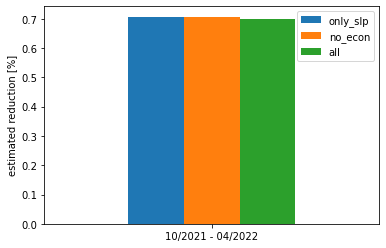

In [26]:
ax = pd.DataFrame(
    data=np.array([
    (results_rdd_all.params.D, results_rdd_no_econ.params.D,  results_rdd_only_slp.params.D), 
    ]), index=["10/2021 - 04/2022"], columns=["only_slp", "no_econ", "all"]
).plot(kind="bar", rot=0)
             
ax.set_ylabel("estimated reduction [%]")

In [27]:
dummy_coefficients = pd.DataFrame(columns=["dummy_coefficients", "P_value"])

for date in pd.date_range("2020-01-01", "2022-03-01", freq="M"):
    
    dummy = pd.concat([
        pd.Series(0,index=df_x_no_holiday.index[df_x_no_holiday.index<date.strftime('%Y-%m-%d')]),
        pd.Series(1,index=df_x_no_holiday.index[df_x_no_holiday.index>=date.strftime('%Y-%m-%d')]),
    ])
    
    df_x_no_holiday["dummy"] = dummy
    
    model = 'rlm ~ 1 + dummy + slp_w2h + time + electricity_from_gas + producing_sector + C(weekday)'
    results = smf.ols(model, df_x_no_holiday).fit(cov_type='HAC', cov_kwds={'maxlags':6})
    
    dummy_coefficients.loc[date.strftime('%Y-%m-%d'), "dummy_coefficients"] = results.params.dummy
    dummy_coefficients.loc[date.strftime('%Y-%m-%d'), "P_value"] = pd.read_html(results.summary().tables[1].as_html(),header=0,index_col=0)[0].loc["dummy"]["P>|t|"]

<ipython-input-27-73f80c5b9564>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x_no_holiday["dummy"] = dummy
<ipython-input-27-73f80c5b9564>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x_no_holiday["dummy"] = dummy
<ipython-input-27-73f80c5b9564>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

/Users/Jarusch/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


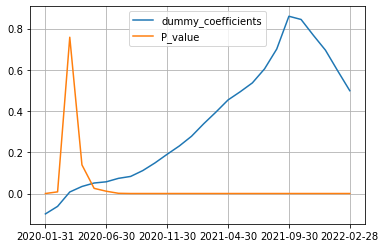

In [28]:
dummy_coefficients.plot()
plt.grid()

### Fitting period variation

In [29]:
#2020/09-2021/08 (before high gas prices)
model_the_20_09 = smf.ols('rlm ~ 1 + slp_w2h + electricity_from_gas + producing_sector + C(weekday)', data=df_x_no_holiday.loc[
    (df_x_no_holiday.index <= high_gas_date)&(df_x_no_holiday.index >= '2020-09-01')])
results_the_20_09 = model_the_20_09.fit(cov_type='HAC', cov_kwds={'maxlags':6}) 

model_the_16_10 = smf.ols('rlm ~ 1 + slp_w2h + electricity_from_gas + producing_sector + C(weekday)', data=df_x_no_holiday.loc[
    (df_x_no_holiday.index <=  high_gas_date)&(df_x_no_holiday.index >= '2016-10-01')])
results_the_16_10 = model_the_16_10.fit(cov_type='HAC', cov_kwds={'maxlags':6}) 

result_list = [
    (results_the_20_09,"fitting period: 2020/09 - 2021/08", '2020-09-01', high_gas_date),
    (results_the_16_10,"fitting period: 2016/10 - 2021/08", '2016-10-01', high_gas_date)
]

#results_the_20_09.summary()
#results_the_16_10.summary()

### Controlvariable variation

In [30]:
#2020/09-2021/08 (before high gas prices)
result_list_2016 = []
for model_name in ["only_slp", "no_econ", "all"]:
    
    model = smf.ols(
        'rlm ~ 1 + slp_w2h + C(weekday)' 
        + ('+ electricity_from_gas' if model_name != 'only_slp' else '')
        + ('+ producing_sector' if model_name == 'all' else '')
        , data=df_x_no_holiday.loc[
        (df_x_no_holiday.index <= high_gas_date)&(df_x_no_holiday.index >= '2020-10-01')]
    )
    results = model.fit() 

    result_list_2016.append((results, model_name))

In [31]:
def prediction(df, name, start_pred, rlm=True):
    delta = pd.DataFrame()
    key_list = ["reported"]

    if rlm == True:
        rlm_slp = "rlm"
    else: 
        rlm_slp = "slp"
        
    df_pred = df.predict(df_x_no_holiday[df_x_no_holiday.index>=start_pred])
    
    df_pred.name = f"{name}_forecast"

    combined = pd.concat([
        df_pred, df_x_no_holiday.loc[df_x_no_holiday.index>=start_pred][rlm_slp]
    ], axis=1, keys=[name, "reported"])
    print(combined.loc[(combined.index >=start_pred)].mean())
    ts = (combined.iloc[:,1]-combined.iloc[:,0])
    ts.name = name 
    delta = pd.concat([delta, ts], axis=1)
    
    return combined, delta, key_list

In [32]:
result_dict = {
    "only_slp": {},
    "no_econ": {},
    "all": {}
}

expected_amount = df_x_no_holiday.loc[df_x_no_holiday.index>=high_gas_date]["rlm"].sum()

In [33]:
start_pred = high_gas_date

for df, name in result_list_2016:
    
    combined, delta, key_list = prediction(df, name, start_pred)
    
    result_dict[name] = (
        delta[name][delta[name].index <= high_gas_date].sum() / expected_amount
    )

only_slp    0.908905
reported    1.594927
dtype: float64
no_econ     0.894213
reported    1.594927
dtype: float64
all         0.896318
reported    1.594927
dtype: float64


Text(0, 0.5, 'estimated reduction [%]')

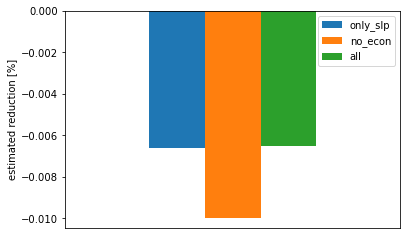

In [34]:
ax = (pd.DataFrame.from_dict(result_dict, orient="index").transpose()*100).plot(kind = "bar", rot=45, xticks=[])
ax.set_ylabel("estimated reduction [%]")



fitting period: 2020/09 - 2021/08    0.858448
reported                             1.137831
dtype: float64


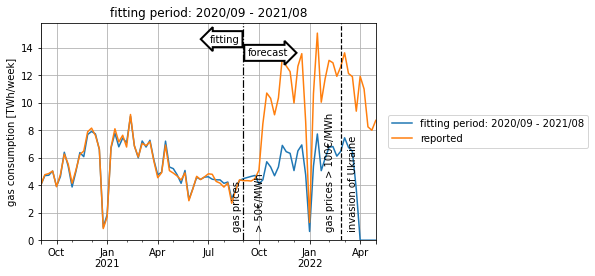

fitting period: 2016/10 - 2021/08    0.811625
reported                             0.898924
dtype: float64


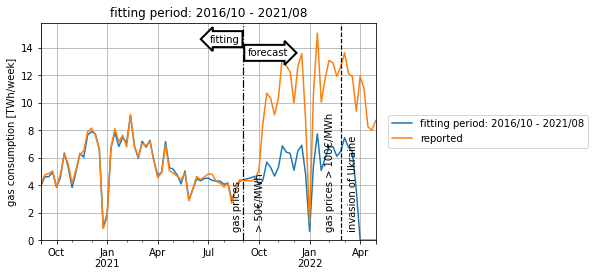

In [35]:
for df, name, start_pred, end_pred in result_list:
    
    combined, delta, key_list = prediction(df, name, start_pred)
    
    ax = combined.loc["2020-09-01":].resample("1w").sum().plot(ylim=0, xlim=("2020-09-01", "2022-04-30"), title = name)
    ax.axvline(x="2022-02-24", color='k', linestyle='--', lw=1.2 )
    ax.axvline(x="2021-08-31", color='k', linestyle='-.', lw=1.2 )
    
    ax.text((pd.to_datetime(high_gas_date)-pd.Timedelta(18, "days")).strftime('%Y-%m-%d'), 0.8, "gas prices" +"\n"+"\n" + "> 50€/MWh", size=10, rotation=90)
    ax.text((pd.to_datetime(invasion_date)-pd.Timedelta(30, "days")).strftime('%Y-%m-%d'), 0.8, "gas prices > 100€/MWh" + "\n" +"\n" + "invasion of Ukraine", size=10, rotation=90)
    
    fit = ax.text(
        (pd.to_datetime(high_gas_date)-pd.Timedelta(6, "days")).strftime('%Y-%m-%d'), 15, "fitting", ha="right", va="top", rotation=0, size=10,
        bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="black", lw=2))
    forecast = ax.text(
        (pd.to_datetime(high_gas_date)+pd.Timedelta(6, "days")).strftime('%Y-%m-%d'), 14, "forecast", ha="left", va="top", rotation=0, size=10,
        bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="black", lw=2))
    
    plt.grid()
    ax.set_ylabel("gas consumption [TWh/week]")
    ax.legend(loc='upper right', bbox_to_anchor=(1.65, 0.6))
    
    plt.show()
    
    key_list.append(name)
    

In [36]:
delta.index = combined.index
delta_rlm = delta.dropna()

Q1_delta_rlm = delta_rlm["2022-02-24":].sum(0)

percent = Q1_delta_rlm / combined.loc["2022-02-24":,"reported"].sum(0)*100

weekly_rlm = Q1_delta_rlm / len(delta_rlm["2022-02-24":].index) * 7

print(
    "since war [TWh]:"+ "\n"+ str(Q1_delta_rlm) + "\n" + "\n" +
    "since war [%]:" + "\n"+ str(percent) + "\n" + "\n" +
    "weekly [TWh]:" + "\n"+ str(weekly_rlm)
     )

since war [TWh]:
fitting period: 2016/10 - 2021/08    23.573591
dtype: float64

since war [%]:
fitting period: 2016/10 - 2021/08    23.102807
dtype: float64

weekly [TWh]:
fitting period: 2016/10 - 2021/08    5.690177
dtype: float64


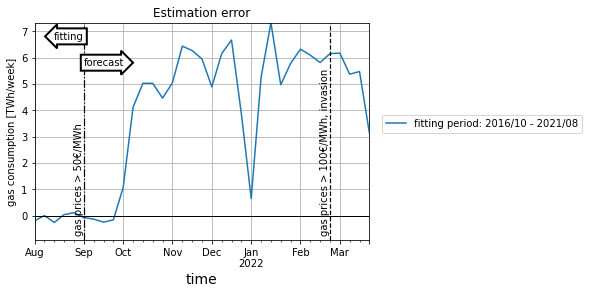

In [37]:
resampled = delta_rlm.resample("1w").sum()

resampled.loc[resampled.index>="2021-08-01"].plot(ylim=delta_rlm["2022-02-24":].min().min(),  title="Estimation error").set_ylabel("gas consumption [TWh/week]")
plt.grid() 
plt.legend(loc='upper right', bbox_to_anchor=(1.7, 0.5))

plt.ylim(resampled.min()[0], resampled.max()[0])


plt.axvline(x="2022-02-24", color='k', linestyle='--', lw=1.2 )
plt.axvline(x="2021-08-31", color='k', linestyle='-.', lw=1.2 )

plt.text((pd.to_datetime(high_gas_date)-pd.Timedelta(9, "days")).strftime('%Y-%m-%d'), -0.7, "gas prices > 50€/MWh", size=10, rotation=90)
plt.text((pd.to_datetime(invasion_date)-pd.Timedelta(9, "days")).strftime('%Y-%m-%d'), -0.7, "gas prices > 100€/MWh" + ", invasion ", size=10, rotation=90)

plt.ylabel("gas consumption [TWh/week]")
plt.legend(loc='upper right', bbox_to_anchor=(1.65, 0.6))
plt.xlabel("time",fontsize=14)
plt.axhline(y=0, color='k', lw=1)

fit = plt.text(
    (pd.to_datetime(high_gas_date)-pd.Timedelta(0, "days")).strftime('%Y-%m-%d'), 7, "fitting", ha="right", va="top", rotation=0, size=10,
    bbox=dict(boxstyle="larrow,pad=0.3", fc="white", ec="black", lw=2))
forecast = plt.text(
    (pd.to_datetime(high_gas_date)+pd.Timedelta(0, "days")).strftime('%Y-%m-%d'), 6, "forecast", ha="left", va="top", rotation=0, size=10,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="black", lw=2))

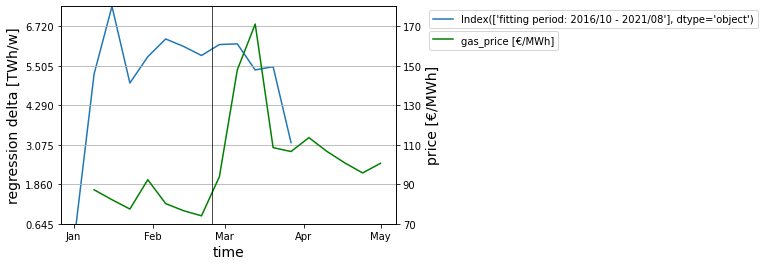

In [38]:
fig,ax = plt.subplots()

column = delta_rlm.columns#[1] 
data = delta_rlm.loc[delta_rlm.index.year==2022, column].resample("w").sum()

ax.plot(data, label=column)

ax.set_ylim(data.min()[0], data.max()[0])
ax.set_xlabel("time",fontsize=14)
ax.set_ylabel("regression delta [TWh/w]", fontsize=14)

step_size = 20 / 110*((data.max() - data.min())[0]) 
ax.set_yticks(np.arange(data.min()[0], data.max()[0], step_size))

ax.legend(loc=(1.1,0.9))

ax2=ax.twinx()
ax2.plot(df_x_no_holiday["prices"][df_x_no_holiday.index.year==2022].resample("w").mean(), color="green", label="gas_price [€/MWh]")

ax2.set_ylabel("price [€/MWh]", fontsize=14)
ax2.set_ylim(70, 180)
ax2.set_yticks(np.arange(70, 180, 20))

ax2.legend(loc=(1.1,0.8))

plt.axvline(x=invasion_date, color='k', lw=0.7)
#plt.axhline(y=0, color='k', lw=1.2)

X = plt.gca().xaxis
X.set_major_locator(mdates.MonthLocator())
X.set_major_formatter(mdates.DateFormatter('%b'))
plt.grid()
plt.show()

## Augmented Dickey-Fuller test for stationarity

In [39]:
print(adfuller(df_x_no_holiday['rlm'].dropna(), regression='nc'))

# p = 0.04910444772233917 -> we can reject the null that the process has a unit root (it can still be seasonal non-stationary, however)

print(adfuller(df_x_no_holiday['slp_w2h'].dropna(), regression='c'))

# we can only reject at 10% confidence level but this might change if bug in 2022 data is fixed

print(adfuller(df_x_no_holiday['electricity_from_gas'].dropna(), regression='c'))

# p = 0.0011084722880644524 -> we can reject the null that the process has a unit root (it can still be seasonal non-stationary, however))

print(adfuller(df_x_no_holiday['producing_sector'].dropna(), regression='c'))

# p = 6.344246220602208e-05 -> we can reject the null that the process has a unit root (it can still be seasonal non-stationary, however)

(-0.45023536394230507, 0.5164587292080141, 19, 1765, {'1%': -2.5670079064915052, '5%': -1.9411532558033258, '10%': -1.6166703850057256}, -3171.2950674058357)
(-2.965621838395224, 0.03823201214187684, 15, 1735, {'1%': -3.4341246405277706, '5%': -2.863207293168388, '10%': -2.5676576190318}, -4548.154071553103)
(-3.809962410179292, 0.002807015464469039, 19, 1765, {'1%': -3.4340603886571697, '5%': -2.863178930152895, '10%': -2.5676425164313974}, 19065.05266262063)
(-4.628269449928415, 0.00011452818735324687, 0, 1784, {'1%': -3.4340208151070124, '5%': -2.8631614607057587, '10%': -2.5676332144347365}, 6967.155222343922)


## KPSS test for stationarity

In [40]:
kpss(df_x_no_holiday['rlm'].dropna(), regression='c')

# p is very large -> we cannot reject the null that the process is (level) stationary (it can still be seasonal non-stationary, however)

kpss(df_x_no_holiday['slp_w2h'].dropna(), regression='c')

# p is very large -> we cannot reject the null that the process is (level) stationary (it can still be seasonal non-stationary, however)

kpss(df_x_no_holiday['electricity_from_gas'].dropna(), regression='c')

# p is very large -> we cannot reject the null that the process is (level) stationary (it can still be seasonal non-stationary, however)

kpss(df_x_no_holiday['producing_sector'].dropna(), regression='c')

# p is very large -> we have to reject the null that the the process is (level) stationary
# CHECK: this is counterintuitive as the DF test finds the opposite

/Users/Jarusch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/Jarusch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1874: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(warn_msg.format(direction="smaller"), InterpolationWarning)
/Users/Jarusch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in

(1.4712326787788965,
 0.01,
 25,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})